In [5]:
import pandas as pd
import seaborn as sns
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np 
import os
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.ensemble import RandomForestRegressor
from keras.layers import Dense, Dropout, BatchNormalization, LSTM
from mlxtend.plotting import plot_confusion_matrix
from keras import callbacks
from tabulate import tabulate

Importing the Data using Pandas

In [6]:
df = pd.read_csv("/content/flight_Dataset.csv")
data = pd.read_csv("/content/flight_Dataset.csv")
df.head()

,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


#PART 1 - Data Collection and Processing

The Dataset has an extra Unnamed column with all unique values, so we need to drop that. 

In [7]:
df.drop("Unnamed: 0" , axis = 1 , inplace = True)
data.drop("Unnamed: 0" , axis = 1 , inplace = True)
df.head()

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


The dataset has a few columns with categorical values; we first need to convert them to numeric values.

In [8]:
print(pd.unique(df['stops']))

['zero' 'one' 'two_or_more']


In [9]:
stops = {'zero':0, 'one':1, 'two_or_more':2 }

In [10]:
label_encoder = preprocessing.LabelEncoder()

df['source_city'] = label_encoder.fit_transform(df['source_city'])
df['airline'] = label_encoder.fit_transform(df['airline'])
df['departure_time'] = label_encoder.fit_transform(df['departure_time'])
df['stops'] = df['stops'].map(stops)
df['destination_city'] = label_encoder.fit_transform(df['destination_city'])
df['arrival_time'] = label_encoder.fit_transform(df['arrival_time'])
df['class'] = label_encoder.fit_transform(df['class'])

df.head()

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,4,SG-8709,2,2,0,5,5,1,2.17,1,5953
1,4,SG-8157,2,1,0,4,5,1,2.33,1,5953
2,0,I5-764,2,1,0,1,5,1,2.17,1,5956
3,5,UK-995,2,4,0,0,5,1,2.25,1,5955
4,5,UK-963,2,4,0,4,5,1,2.33,1,5955


Check if any column have any None (NA) values.

In [11]:
df.isna().any()

airline             False
flight              False
source_city         False
departure_time      False
stops               False
arrival_time        False
destination_city    False
class               False
duration            False
days_left           False
price               False
dtype: bool

Check if any outlier exists.
Since, Dataset does not follow normal distribution, we will use Interquartile Range (IQR).

In [12]:
df.describe()

,airline,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
count,300153.000000,300153.000000,300153.000000,300153.000000,300153.000000,300153.000000,300153.000000,300153.000000,300153.000000,300153.000000
mean,3.104873,2.577592,2.417337,0.924312,3.074086,2.588303,0.688536,12.221021,26.004751,20889.660523
std,1.833265,1.751762,1.754276,0.398106,1.741666,1.744543,0.463093,7.191997,13.561004,22697.767366
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.830000,1.000000,1105.000000
25%,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,0.000000,6.830000,15.000000,4783.000000
50%,3.000000,2.000000,2.000000,1.000000,4.000000,3.000000,1.000000,11.250000,26.000000,7425.000000
75%,5.000000,4.000000,4.000000,1.000000,5.000000,4.000000,1.000000,16.170000,38.000000,42521.000000
max,5.000000,5.000000,5.000000,2.000000,5.000000,5.000000,1.000000,49.830000,49.000000,123071.000000


In [13]:
# The function to find the IQR and detect any outliers
# If they are 1.5 times above or below IQR then it is outlier
def find_outliers_IQR(df):
   q1=df.quantile(0.25)
   q3=df.quantile(0.75)
   IQR=q3-q1
   outliers = df[((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))]
   return outliers

In [14]:
# Outliers in duration columns

outliers_duration = find_outliers_IQR(df['duration'])
print('number of outliers: ' + str(len(outliers_duration)))
print('max outlier value: ' + str(outliers_duration.max()))
print('min outlier value: '+ str(outliers_duration.min()))

number of outliers: 2110
max outlier value: 49.83
min outlier value: 30.25


In [15]:
# Outliers in price columns

outliers_price= find_outliers_IQR(df['price'])
print('number of outliers: ' + str(len(outliers_price)))
print('max outlier value: ' + str(outliers_price.max()))
print('min outlier value: '+ str(outliers_price.min()))

number of outliers: 123
max outlier value: 123071
min outlier value: 99129


In [16]:
# Dropping the Outliers
def drop_outliers_IQR(df):
   q1=df.quantile(0.25)
   q3=df.quantile(0.75)
   IQR=q3-q1
   not_outliers = df[~((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))]
   return not_outliers

df = drop_outliers_IQR(df)
df

<ipython-input-16-0e08388351f7>:3: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  q1=df.quantile(0.25)
<ipython-input-16-0e08388351f7>:4: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  q3=df.quantile(0.75)
<ipython-input-16-0e08388351f7>:6: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  not_outliers = df[~((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))]


,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,4,SG-8709,2,2,NaN,5,5,1,2.17,1,5953.0
1,4,SG-8157,2,1,NaN,4,5,1,2.33,1,5953.0
2,0,I5-764,2,1,NaN,1,5,1,2.17,1,5956.0
3,5,UK-995,2,4,NaN,0,5,1,2.25,1,5955.0
4,5,UK-963,2,4,NaN,4,5,1,2.33,1,5955.0
...,...,...,...,...,...,...,...,...,...,...,...
300148,5,UK-822,1,4,1.0,2,3,0,10.08,49,69265.0
300149,5,UK-826,1,0,1.0,5,3,0,10.42,49,77105.0
300150,5,UK-832,1,1,1.0,5,3,0,13.83,49,79099.0
300151,5,UK-828,1,1,1.0,2,3,0,10.00,49,81585.0


In [17]:
df = df.fillna(0)
df

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,4,SG-8709,2,2,0.0,5,5,1,2.17,1,5953.0
1,4,SG-8157,2,1,0.0,4,5,1,2.33,1,5953.0
2,0,I5-764,2,1,0.0,1,5,1,2.17,1,5956.0
3,5,UK-995,2,4,0.0,0,5,1,2.25,1,5955.0
4,5,UK-963,2,4,0.0,4,5,1,2.33,1,5955.0
...,...,...,...,...,...,...,...,...,...,...,...
300148,5,UK-822,1,4,1.0,2,3,0,10.08,49,69265.0
300149,5,UK-826,1,0,1.0,5,3,0,10.42,49,77105.0
300150,5,UK-832,1,1,1.0,5,3,0,13.83,49,79099.0
300151,5,UK-828,1,1,1.0,2,3,0,10.00,49,81585.0


In [18]:
df.describe()

,airline,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
count,300153.000000,300153.000000,300153.000000,300153.000000,300153.000000,300153.000000,300153.000000,300153.000000,300153.000000,300153.000000
mean,3.104873,2.577592,2.417337,0.835784,3.074086,2.588303,0.688536,11.987793,26.004751,20846.780349
std,1.833265,1.751762,1.754276,0.370472,1.741666,1.744543,0.463093,7.041614,13.561004,22638.072173
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,0.000000,6.670000,15.000000,4783.000000
50%,3.000000,2.000000,2.000000,1.000000,4.000000,3.000000,1.000000,11.170000,26.000000,7425.000000
75%,5.000000,4.000000,4.000000,1.000000,5.000000,4.000000,1.000000,16.000000,38.000000,42521.000000
max,5.000000,5.000000,5.000000,1.000000,5.000000,5.000000,1.000000,30.170000,49.000000,98972.000000


#PART 2 - Data Exploration and Visulization

1. Number of Passengers for each Airlines

In [19]:
# Total Airlines
data['airline'].unique()

array(['SpiceJet', 'AirAsia', 'Vistara', 'GO_FIRST', 'Indigo',
       'Air_India'], dtype=object)

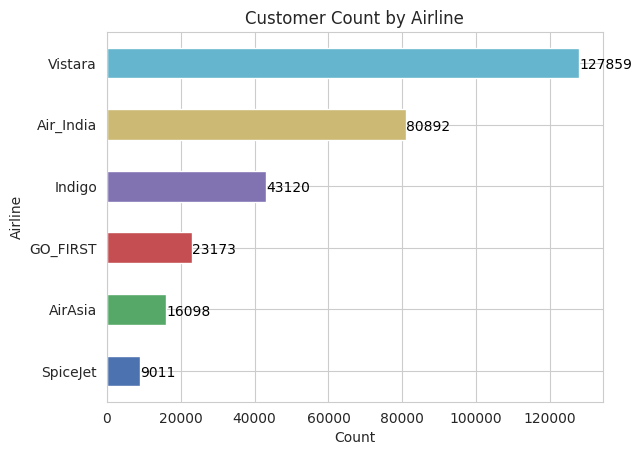

In [20]:
airline_counts = data['airline'].value_counts().sort_values(ascending=True)
sns.set_style("whitegrid")
colors = ['#4C72B0', '#55A868', '#C44E52', '#8172B2', '#CCB974', '#64B5CD']

# Create horizontal bar chart of airline counts
airline_counts.plot(kind='barh', color=colors)
for i, v in enumerate(airline_counts):
    plt.text(v+1 , i-0.1, str(v), color='black')
plt.title("Customer Count by Airline")
plt.xlabel("Count")
plt.ylabel("Airline")
plt.show()

2. Average ticket price for each airline


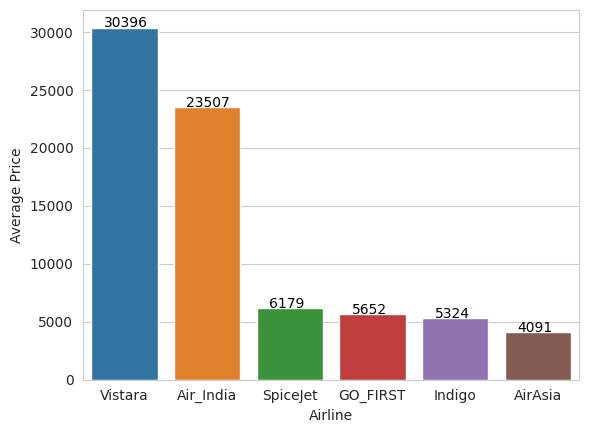

In [21]:
avg_price = data.groupby('airline')['price'].mean().reset_index()
avg_price = avg_price.sort_values(by='price',ascending=False)
sns.barplot(x='airline', y='price', data=avg_price)
for i,v in enumerate(avg_price['price']):
    plt.text(i-0.25 , int(v)+10, str(int(v)), color='black')
plt.xlabel('Airline')
plt.ylabel('Average Price')
plt.show()

3. Number of passengers in Business and Economy Class

In [22]:
class_counts = data['class'].value_counts()
class_counts

Economy     206666
Business     93487
Name: class, dtype: int64

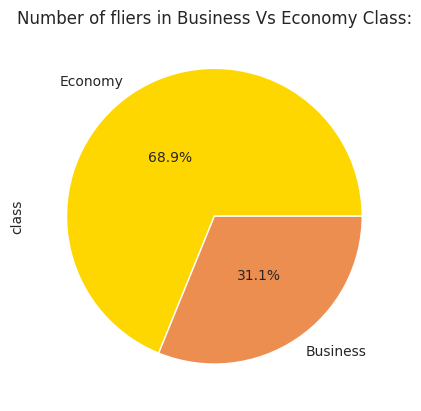

In [23]:
percentages = [(value/sum(class_counts))*100 for value in class_counts]
colors = ['#FFD700', '#ed8e51']
class_counts.plot(kind='pie', colors=colors)
plt.text(x=-0.3, y=0.4, s=f'{percentages[0]:.1f}%', horizontalalignment='center', verticalalignment='center')
plt.text(x=0.3, y=-0.4, s=f'{percentages[1]:.1f}%', horizontalalignment='center', verticalalignment='center')
plt.title("Number of fliers in Business Vs Economy Class:")
plt.show()

4. Ticket prices based on class¶


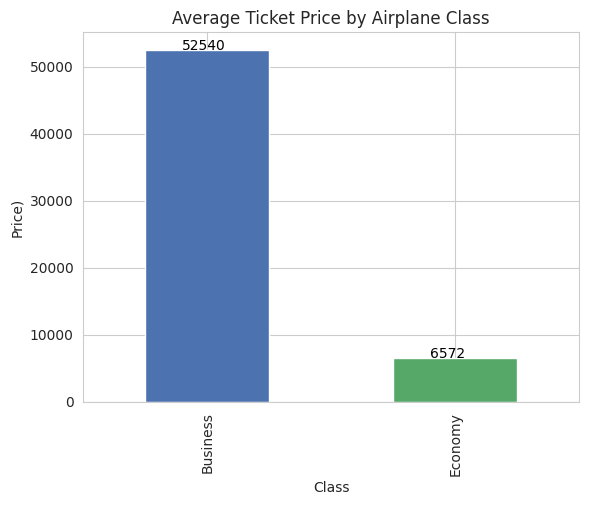

In [24]:
class_prices = data.groupby('class')['price'].mean()
sns.set_style("whitegrid")
class_prices.plot(kind='bar', color=['#4C72B0', '#55A868'])
for i,v in enumerate(class_prices):
    plt.text(i-0.1 , int(v)+50, str(int(v)), color='black')
plt.title("Average Ticket Price by Airplane Class")
plt.xlabel("Class")
plt.ylabel("Price)")
plt.show()

5. Ticket prices based on duration of flight¶


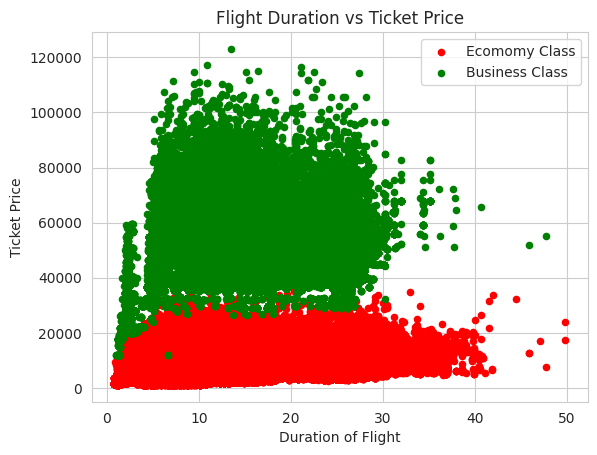

In [25]:
ax = data[data['class']=='Economy'].plot(x="duration", y="price", color="Red", label="Ecomomy Class", kind='scatter')
data[data['class']=='Business'].plot(x="duration", y="price", color="Green", label="Business Class", kind='scatter', ax = ax)

plt.title("Flight Duration vs Ticket Price")
plt.xlabel("Duration of Flight")
plt.ylabel("Ticket Price")
plt.show()

6. Relation between number of stops for a flight and the flight ticket price


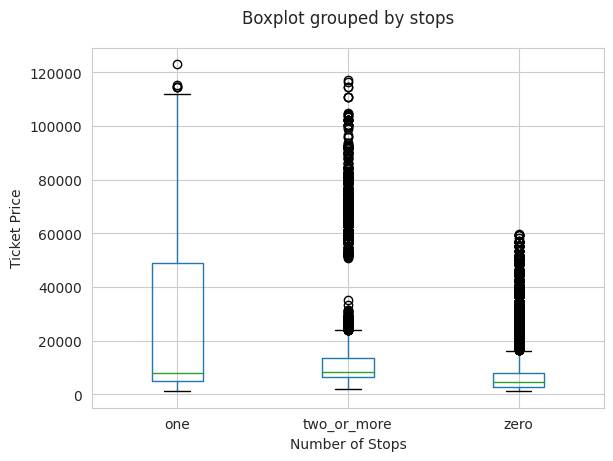

In [26]:
data.boxplot(column='price', by='stops')
plt.title("")
plt.xlabel("Number of Stops")
plt.ylabel("Ticket Price")
plt.show()

Scaling the Data

In [27]:
df = df.drop('flight', axis = 1)
df

,airline,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,4,2,2,0.0,5,5,1,2.17,1,5953.0
1,4,2,1,0.0,4,5,1,2.33,1,5953.0
2,0,2,1,0.0,1,5,1,2.17,1,5956.0
3,5,2,4,0.0,0,5,1,2.25,1,5955.0
4,5,2,4,0.0,4,5,1,2.33,1,5955.0
...,...,...,...,...,...,...,...,...,...,...
300148,5,1,4,1.0,2,3,0,10.08,49,69265.0
300149,5,1,0,1.0,5,3,0,10.42,49,77105.0
300150,5,1,1,1.0,5,3,0,13.83,49,79099.0
300151,5,1,1,1.0,2,3,0,10.00,49,81585.0


In [28]:
names = df.columns
indexes = df.index
sc = MinMaxScaler((0, 1)) #between 0 and 1 range
df = sc.fit_transform(df)
data_scaled = pd.DataFrame(df, columns=names, index=indexes)
data_scaled.head()

,airline,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,0.8,0.4,0.4,0.0,1.0,1.0,1.0,0.071926,0.0,0.060148
1,0.8,0.4,0.2,0.0,0.8,1.0,1.0,0.077229,0.0,0.060148
2,0.0,0.4,0.2,0.0,0.2,1.0,1.0,0.071926,0.0,0.060179
3,1.0,0.4,0.8,0.0,0.0,1.0,1.0,0.074577,0.0,0.060169
4,1.0,0.4,0.8,0.0,0.8,1.0,1.0,0.077229,0.0,0.060169


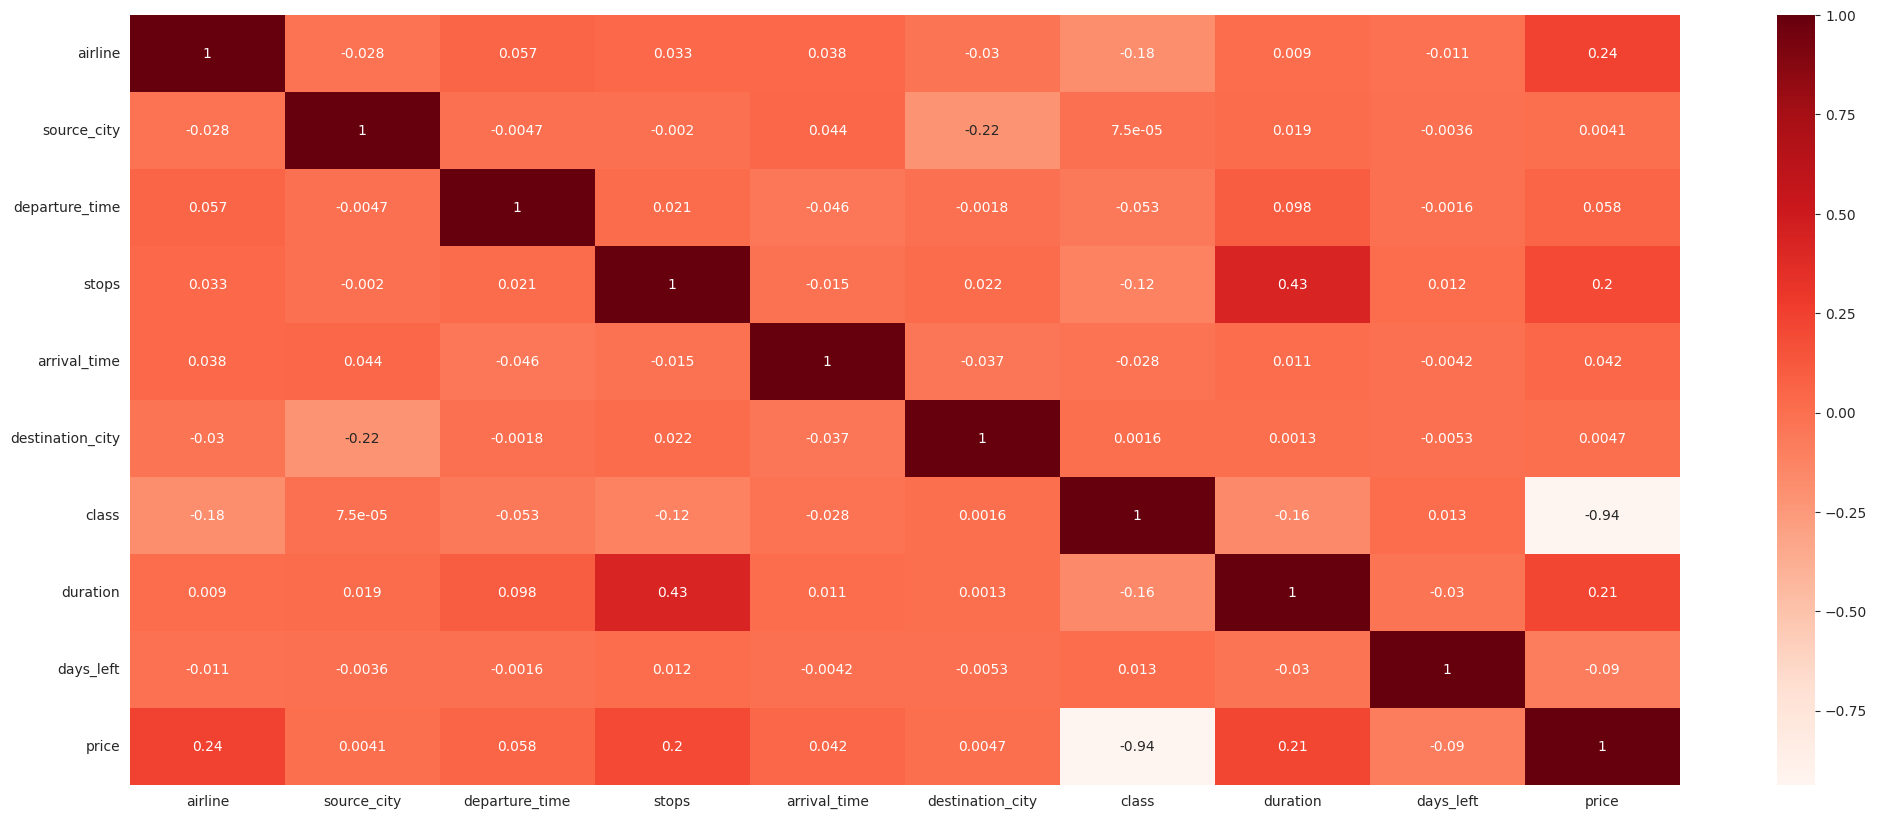

In [29]:
#Using Pearson Correlation
plt.figure(figsize=(25,10))
cor = data_scaled.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [30]:
cor_target = cor["price"]

relevant_features = cor_target
relevant_features 

airline             0.242042
source_city         0.004124
departure_time      0.058065
stops               0.200768
arrival_time        0.041719
destination_city    0.004731
class              -0.937517
duration            0.214473
days_left          -0.089711
price               1.000000
Name: price, dtype: float64

#PART 3 - Model Exploration and Model Selection

Spliting the data into Train (60%), Validation(25%), and Test(15%) set.

In [31]:
#Target variable
y = data_scaled['price']

#Input variables
X = data_scaled.drop(['price'],axis=1)

X_train, X_1, y_train, y_1 = train_test_split(X, y , test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_1, y_1 , test_size=0.375, random_state=42)

In [32]:
print(len(y), len(y_train), len(y_val), len(y_test))

300153 180091 75038 45024


##1 - Linear Regression

In [33]:
linear_regression = LinearRegression()
linear_regression.fit(X_train, y_train)
y_pred_lr = linear_regression.predict(X_val)

In [34]:
score_lr = linear_regression.score(X_val, y_val)
mse_lr = mean_squared_error(y_val, y_pred_lr)
r2_lr = r2_score(y_val, y_pred_lr)
mae_lr = mean_absolute_error(y_val, y_pred_lr)

print("Accuracy of Model: ","{:.2f}".format(score_lr*100),'%')
print("MAE: ","{:.4f}".format(mae_lr))
print("MSE: ","{:.4f}".format(mse_lr))
print("R-Squared: ","{:.2f}".format(r2_lr*100),'%')

Accuracy of Model:  90.03 %
MAE:  0.0467
MSE:  0.0052
R-Squared:  90.03 %


<Axes: xlabel='price'>

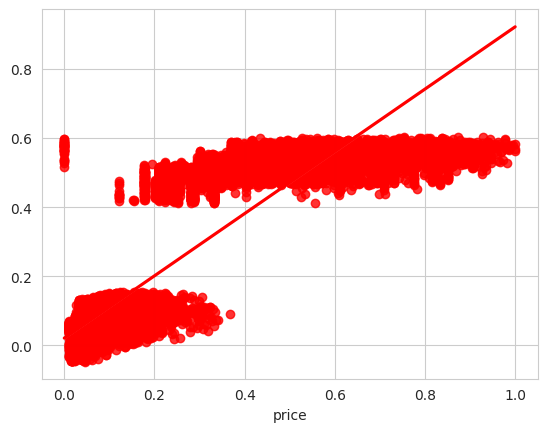

In [35]:
sns.regplot(x=y_val, y=y_pred_lr, color='red')

##2 - Polynomial Regression

In [36]:
poly = PolynomialFeatures(degree=4)
X_train_poly = poly.fit_transform(X_train)
X_val_poly = poly.transform(X_val)
X_test_poly = poly.transform(X_test)

linear_poly = LinearRegression()
linear_poly.fit(X_train_poly, y_train)
y_pred_poly = linear_poly.predict(X_val_poly)

In [37]:
score_poly = linear_poly.score(X_val_poly, y_val)
mse_poly = mean_squared_error(y_val, y_pred_poly)
r2_poly = r2_score(y_val, y_pred_poly)
mae_poly = mean_absolute_error(y_val, y_pred_poly)

print("Accuracy of Model: ","{:.2f}".format(score_poly*100),'%')
print("MAE: ","{:.4f}".format(mae_poly))
print("MSE: ","{:.4f}".format(mse_poly))
print("R-Squared: ","{:.2f}".format(r2_poly*100),'%')

Accuracy of Model:  94.93 %
MAE:  0.0313
MSE:  0.0027
R-Squared:  94.93 %


<Axes: xlabel='price'>

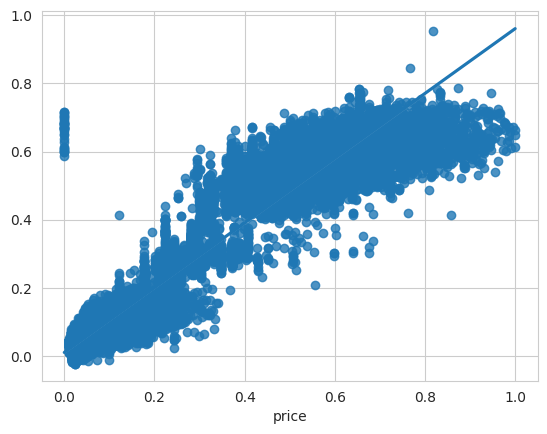

In [38]:
sns.regplot(x=y_val, y=y_pred_poly)

##3 - Decision Tree

In [39]:
dt = DecisionTreeRegressor(max_depth = 10, min_samples_split=15)

dt.fit(X_train, y_train)

y_pred_dt = dt.predict(X_val)

In [40]:
score_dt = dt.score(X_val, y_val)
mse_dt = mean_squared_error(y_val, y_pred_dt)
r2_dt = r2_score(y_val, y_pred_dt)
mae_dt = mean_absolute_error(y_val, y_pred_dt)

print("Accuracy of Model: ","{:.2f}".format(score_dt*100),'%')
print("MAE: ","{:.4f}".format(mae_dt))
print("MSE: ","{:.4f}".format(mse_dt))
print("R-Squared: ","{:.2f}".format(r2_dt*100),'%')

Accuracy of Model:  95.78 %
MAE:  0.0255
MSE:  0.0022
R-Squared:  95.78 %


<Axes: xlabel='price'>

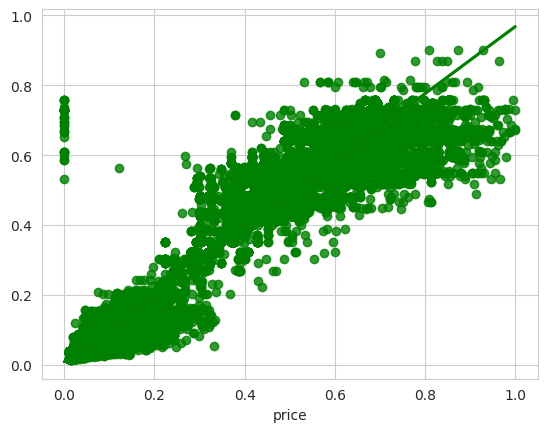

In [41]:
sns.regplot(x=y_val, y=y_pred_dt, color = 'green')

##4 - Regression Tree

In [42]:
rt = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)

rt.fit(X_train, y_train)

y_pred_rt = rt.predict(X_val)

In [43]:
score_rt = rt.score(X_val, y_val)
mse_rt = mean_squared_error(y_val, y_pred_rt)
r2_rt = r2_score(y_val, y_pred_rt)
mae_rt = mean_absolute_error(y_val, y_pred_rt)

print("Accuracy of Model: ","{:.2f}".format(score_rt*100),'%')
print("MAE: ","{:.4f}".format(mae_rt))
print("MSE: ","{:.4f}".format(mse_rt))
print("R-Squared: ","{:.2f}".format(r2_rt*100),'%')

Accuracy of Model:  96.07 %
MAE:  0.0243
MSE:  0.0021
R-Squared:  96.07 %


<Axes: xlabel='price'>

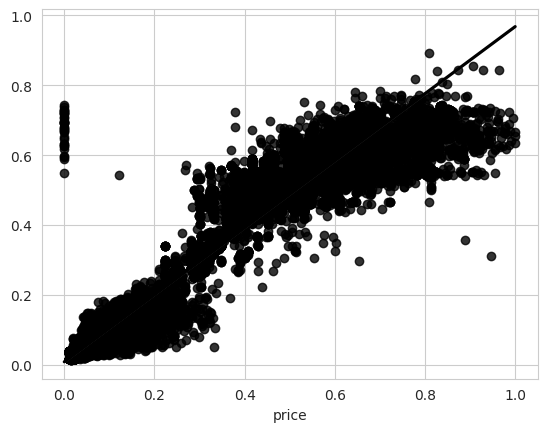

In [44]:
sns.regplot(x=y_val, y=y_pred_rt, color = 'black')

## 5 - KNN

In [45]:
KNN = KNeighborsRegressor(n_neighbors=5)

KNN.fit(X_train, y_train)

y_pred_knn = KNN.predict(X_val)

In [46]:
score_knn = KNN.score(X_val, y_val)
mse_knn = mean_squared_error(y_val, y_pred_knn)
r2_knn = r2_score(y_val, y_pred_knn)
mae_knn = mean_absolute_error(y_val, y_pred_knn)

print("Accuracy of Model: ","{:.2f}".format(score_knn*100),'%')
print("MAE: ","{:.4f}".format(mae_knn))
print("MSE: ","{:.4f}".format(mse_knn))
print("R-Squared: ","{:.2f}".format(r2_knn*100),'%')

Accuracy of Model:  96.60 %
MAE:  0.0196
MSE:  0.0018
R-Squared:  96.60 %


<Axes: xlabel='price'>

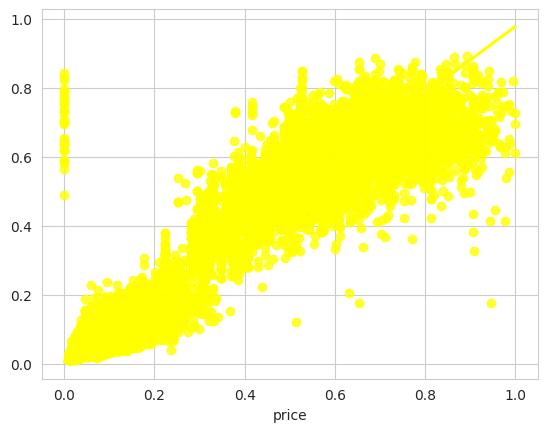

In [47]:
sns.regplot(x=y_val, y=y_pred_knn, color = 'yellow')

Neural Network

In [65]:
print(X_train.shape, y_train.shape)

(180091, 9) (180091,)


In [67]:
NN = Sequential()
NN.add(Dense(5, input_dim = X_train.shape[1], activation = 'relu'))
NN.add(Dense(1))
NN.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 5)                 50        
                                                                 
 dense_22 (Dense)            (None, 1)                 6         
                                                                 
Total params: 56
Trainable params: 56
Non-trainable params: 0
_________________________________________________________________


In [69]:
NN.compile(loss='mean_squared_error', optimizer='sgd', metrics=['accuracy','mean_squared_error','mean_absolute_error']) 
history = NN.fit(X_train, y_train,validation_data = (X_val,y_val), epochs= 20, batch_size=64)

Epoch 1/20
2814/2814 [==============================] - 14s 4ms/step - loss: 0.0341 - accuracy: 3.3316e-04 - mean_squared_error: 0.0341 - mean_absolute_error: 0.1409 - val_loss: 0.0090 - val_accuracy: 9.3286e-05 - val_mean_squared_error: 0.0090 - val_mean_absolute_error: 0.0665
Epoch 2/20
2814/2814 [==============================] - 10s 4ms/step - loss: 0.0065 - accuracy: 1.0550e-04 - mean_squared_error: 0.0065 - mean_absolute_error: 0.0536 - val_loss: 0.0054 - val_accuracy: 6.6633e-05 - val_mean_squared_error: 0.0054 - val_mean_absolute_error: 0.0474
Epoch 3/20
2814/2814 [==============================] - 14s 5ms/step - loss: 0.0050 - accuracy: 1.0550e-04 - mean_squared_error: 0.0050 - mean_absolute_error: 0.0460 - val_loss: 0.0048 - val_accuracy: 6.6633e-05 - val_mean_squared_error: 0.0048 - val_mean_absolute_error: 0.0445
Epoch 4/20
2814/2814 [==============================] - 15s 5ms/step - loss: 0.0046 - accuracy: 1.1661e-04 - mean_squared_error: 0.0046 - mean_absolute_error: 0.04

In [74]:
y_pred_nn = NN.predict(X_val)

mse_nn = mean_squared_error(y_val, y_pred_nn)
r2_nn = r2_score(y_val, y_pred_nn)
mae_nn = mean_absolute_error(y_val, y_pred_nn)

print("MAE: ","{:.4f}".format(mae_nn))
print("MSE: ","{:.4f}".format(mse_nn))
print("R-Squared: ","{:.2f}".format(r2_nn*100),'%')

2345/2345 [==============================] - 6s 3ms/step
MAE:  0.0411
MSE:  0.0042
R-Squared:  91.95 %


Now, summarize all the model.

In [80]:
def calculate_cumulative_count_and_rate(y_true, y_pred):
  results_df = pd.DataFrame()
  results_df['target'] = y_true
  results_df['predicted'] = y_pred
  results_df = results_df.sort_values(by='predicted', ascending=False)

  results_df['cumulative_count'] = np.arange(1, len(results_df)+1)
  results_df['cumulative_pos'] = results_df['target'].cumsum()
  results_df['cumulative_rate'] = results_df['cumulative_pos'] / results_df['target'].sum()
  return results_df[['cumulative_count','cumulative_pos','cumulative_rate','target']]

In [81]:
results_lr = calculate_cumulative_count_and_rate(y_val, y_pred_lr)
results_poly = calculate_cumulative_count_and_rate(y_val, y_pred_poly)
results_dt = calculate_cumulative_count_and_rate(y_val, y_pred_dt)
results_rt = calculate_cumulative_count_and_rate(y_val, y_pred_rt)
results_knn = calculate_cumulative_count_and_rate(y_val, y_pred_knn)
results_nn = calculate_cumulative_count_and_rate(y_val, y_pred_nn)

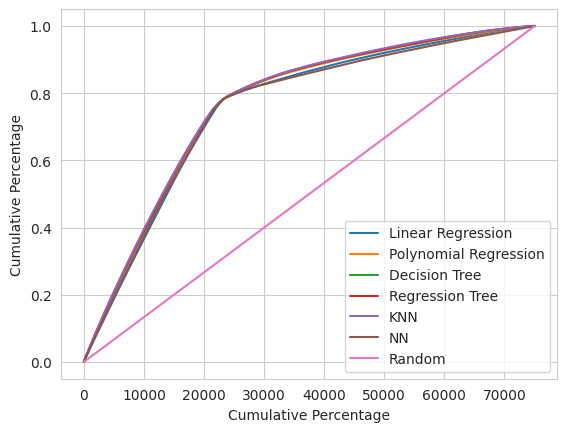

In [82]:
random_rates = np.linspace(0, 1, len(results_lr))

plt.plot(results_lr['cumulative_count'], results_lr['cumulative_rate'], label='Linear Regression')
plt.plot(results_poly['cumulative_count'], results_poly['cumulative_rate'], label='Polynomial Regression')
plt.plot(results_dt['cumulative_count'], results_dt['cumulative_rate'], label='Decision Tree')
plt.plot(results_rt['cumulative_count'], results_rt['cumulative_rate'], label='Regression Tree')
plt.plot(results_knn['cumulative_count'], results_knn['cumulative_rate'], label='KNN')
plt.plot(results_nn['cumulative_count'], results_nn['cumulative_rate'], label='NN')

plt.plot(results_lr['cumulative_count'], random_rates, label='Random')
plt.xlabel('Cumulative Percentage')
plt.ylabel('Cumulative Percentage')
plt.legend()
plt.show()



In [84]:
auc_lr = np.trapz(results_lr['cumulative_rate'], x=results_lr['cumulative_count']) / (len(results_lr) * results_lr['target'].mean())
auc_poly = np.trapz(results_poly['cumulative_rate'], x=results_poly['cumulative_count']) / (len(results_poly) * results_poly['target'].mean())
auc_dt = np.trapz(results_dt['cumulative_rate'], x=results_dt['cumulative_count']) / (len(results_dt) * results_dt['target'].mean())
auc_rt = np.trapz(results_rt['cumulative_rate'], x=results_rt['cumulative_count']) / (len(results_rt) * results_rt['target'].mean())
auc_knn = np.trapz(results_knn['cumulative_rate'], x=results_knn['cumulative_count']) / (len(results_knn) * results_knn['target'].mean())
auc_nn = np.trapz(results_nn['cumulative_rate'], x=results_nn['cumulative_count']) / (len(results_nn) * results_nn['target'].mean())


In [85]:
models = [['Model', 'Accuracy', 'R-squared', 'MSE', 'MAE', 'AUC'], 
         ['Linear Regression', "{:.2f}".format(score_lr*100)+ '%',"{:.2f}".format(r2_lr*100)+'%', "{:.4f}".format(mse_lr), "{:.4f}".format(mae_lr),"{:.4f}".format(auc_lr)], 
         ['Polynomial Regression (n=4)', "{:.2f}".format(score_poly*100)+ '%', "{:.2f}".format(r2_poly*100)+'%', "{:.4f}".format(mse_poly), "{:.4f}".format(mae_poly),"{:.4f}".format(auc_poly)] , 
         ['Decisoion Tree', "{:.2f}".format(score_dt*100)+ '%',  "{:.2f}".format(r2_dt*100)+'%', "{:.4f}".format(mse_dt), "{:.4f}".format(mae_dt),"{:.4f}".format(auc_dt)],
         ['Regression Tree', "{:.2f}".format(score_rt*100)+ '%',  "{:.2f}".format(r2_rt*100)+'%', "{:.4f}".format(mse_rt), "{:.4f}".format(mae_rt),"{:.4f}".format(auc_rt)],
        ['KNN', "{:.2f}".format(score_knn*100)+ '%',  "{:.2f}".format(r2_knn*100)+'%', "{:.4f}".format(mse_knn), "{:.4f}".format(mae_knn), "{:.4f}".format(auc_knn)],
        ['NN',  "{:.2f}".format(r2_nn*100)+'%',  "{:.2f}".format(r2_nn*100)+'%', "{:.4f}".format(mse_nn), "{:.4f}".format(mae_nn), "{:.4f}".format(auc_nn)]]

print(tabulate(models, headers = 'firstrow'))

Model                        Accuracy    R-squared       MSE     MAE     AUC
---------------------------  ----------  -----------  ------  ------  ------
Linear Regression            90.03%      90.03%       0.0052  0.0467  3.5901
Polynomial Regression (n=4)  94.93%      94.93%       0.0027  0.0313  3.6338
Decisoion Tree               95.78%      95.78%       0.0022  0.0255  3.6437
Regression Tree              96.07%      96.07%       0.0021  0.0243  3.6467
KNN                          96.60%      96.60%       0.0018  0.0196  3.6549
NN                           91.95%      91.95%       0.0042  0.0411  3.5785


## 5. Performance Evaluation and Interpretation

From all the evaluations above, KNN has the lowest error.

In [86]:
# predicting the test values
y_pred_test = KNN.predict(X_test)

In [89]:
# evaluation score for test set
score_test = rt.score(X_test, y_test)
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)

print("Accuracy: ","{:.2f}".format(score_test*100),'%')
print("MSE: ","{:.4f}".format(mse_test))
print("MAE: ","{:.4f}".format(mae_test))
print("R-Squared: ","{:.2f}".format(r2_test*100),'%')

Accuracy:  96.13 %
MSE:  0.0017
MAE:  0.0194
R-Squared:  96.71 %
